# Mass per module area calculations for Encapsulants and Backsheets

In [1]:
import numpy as np
import pandas as pd
import os,sys
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
plt.rcParams['figure.figsize'] = (12, 8)

Import the supporting material files

## Encapsulants

In [2]:
cwd = os.getcwd() #grabs current working directory
skipcols = ['Source', 'Notes']
encapsulants_thick_raw = pd.read_csv(cwd+"/../../../PV_ICE/baselines/SupportingMaterial/encapsulants-thickness-micron.csv",
                                     index_col='year', usecols=lambda x: x not in skipcols)
encapsulants_market_raw = pd.read_csv(cwd+"/../../../PV_ICE/baselines/SupportingMaterial/encapsulants-marketshares-global.csv",
                                      index_col='year', usecols=lambda x: x not in skipcols)

In [3]:
#what materials:
print(encapsulants_thick_raw.columns)
print(encapsulants_market_raw.columns)
#there is one column in marketshare that is a blend of two materials

Index(['EVA', 'TPU', 'PVB', 'Polyolefin', 'PDMS'], dtype='object')
Index(['EVA', 'EVA+PO', 'Polyolefin', 'TPU', 'PVB', 'PDMS'], dtype='object')


ITRPV provides the thickness and marketshare data for the different encapsulants. For each material, the thickness needs to be multiplied by the material density to obtain mass per module area.

* EVA: Product datasheets from several companies report values of 0.96 and 0.92 g/cm^3 spanning from 2013 to 2021.
* TPU: 
* PVB: 1.075 g/cm^3 from wmcglass, 
* Polyolefin: 0.88 g/cm^ from almaden, 0.8683 to 0.88 g/cm^3 from 3M
* PDMS: 965 kg/m3 from wikipedia

Create a dataframe with the densities of the different materials:

In [4]:
#create dictionary with these materials, 1E6 is converting to g/m3 from cm3
encaps_density = {
    'EVA' : np.mean([0.96,0.92])*1E6, #g/m^3
    'TPU' : 1.21*1E6, #https://bitfab.io/
    'PVB' : 1.075*1E6, #g/m^3
    'Polyolefin' : 0.88*1E6, #g/m^3
    'PDMS' : 0.965*1E6 #g/m3
}
print(encaps_density)

{'EVA': 940000.0, 'TPU': 1210000.0, 'PVB': 1075000.0, 'Polyolefin': 880000.0, 'PDMS': 965000.0}


First, change the marketshares into percentages, and fill in missing values.

<AxesSubplot:xlabel='year'>

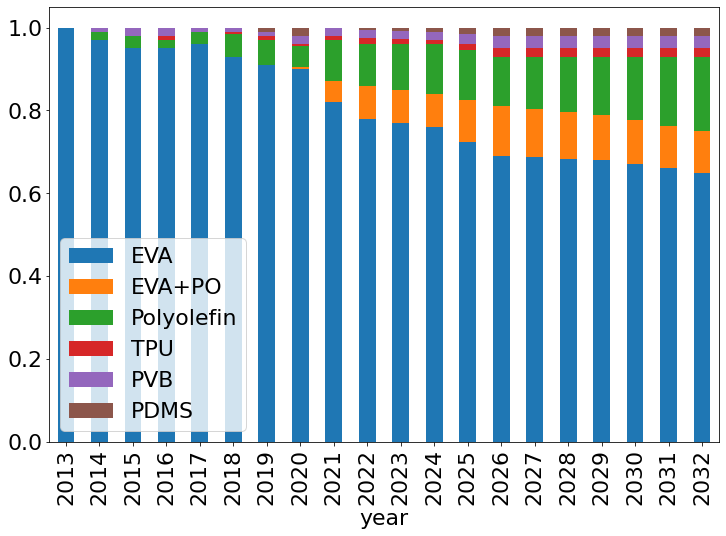

In [5]:
encapsulants_market_pct = encapsulants_market_raw/100
#interpolate
encap_market_pct_interp = encapsulants_market_pct.interpolate(method='linear',axis=0,limit=2,limit_area='inside')
#fill na with 0
encap_market_pct_full = encap_market_pct_interp.fillna(0.0)

check = pd.DataFrame(encap_market_pct_full.agg("sum", axis="columns"))
#print(check)
#make a bar plot
encap_market_pct_full.plot(kind='bar', stacked=True)

In [6]:
#check if marketshare and thickness dataframes have same index
if (len(encap_market_pct_full.index) == len(encapsulants_thick_raw.index)) & (encap_market_pct_full.index[0] == encapsulants_thick_raw.index[0]):
    print("indexes are equal, proceed.")
else:
    print("check dataframe index")

print(encap_market_pct_full.columns)
print(encapsulants_thick_raw.columns)

check dataframe index
Index(['EVA', 'EVA+PO', 'Polyolefin', 'TPU', 'PVB', 'PDMS'], dtype='object')
Index(['EVA', 'TPU', 'PVB', 'Polyolefin', 'PDMS'], dtype='object')


In [7]:
#fill in thickness dataframe
encapsulants_thick_interp = encapsulants_thick_raw.interpolate(method='linear',axis=0, limit_direction='both')
#thickness data is in micron, convert to meter
encaps_thick_m = encapsulants_thick_interp/1E6
print(encaps_thick_m)

           EVA       TPU       PVB  Polyolefin      PDMS
year                                                    
2013  0.000450  0.000450  0.000500    0.000475  0.000500
2014  0.000450  0.000450  0.000500    0.000475  0.000500
2015  0.000450  0.000450  0.000500    0.000475  0.000500
2016  0.000450  0.000450  0.000500    0.000475  0.000500
2017  0.000450  0.000450  0.000500    0.000475  0.000500
2018  0.000450  0.000450  0.000500    0.000475  0.000500
2019  0.000450  0.000450  0.000500    0.000475  0.000500
2020  0.000450  0.000450  0.000500    0.000475  0.000500
2021  0.000450  0.000450  0.000500    0.000475  0.000500
2022  0.000450  0.000438  0.000487    0.000463  0.000475
2023  0.000450  0.000425  0.000475    0.000450  0.000450
2024  0.000438  0.000420  0.000452    0.000440  0.000435
2025  0.000425  0.000415  0.000430    0.000430  0.000420
2026  0.000417  0.000410  0.000420    0.000420  0.000413
2027  0.000408  0.000405  0.000410    0.000410  0.000407
2028  0.000400  0.000400  0.000

Now multiply by densities to get mass per meter sq., then weight by marketshare

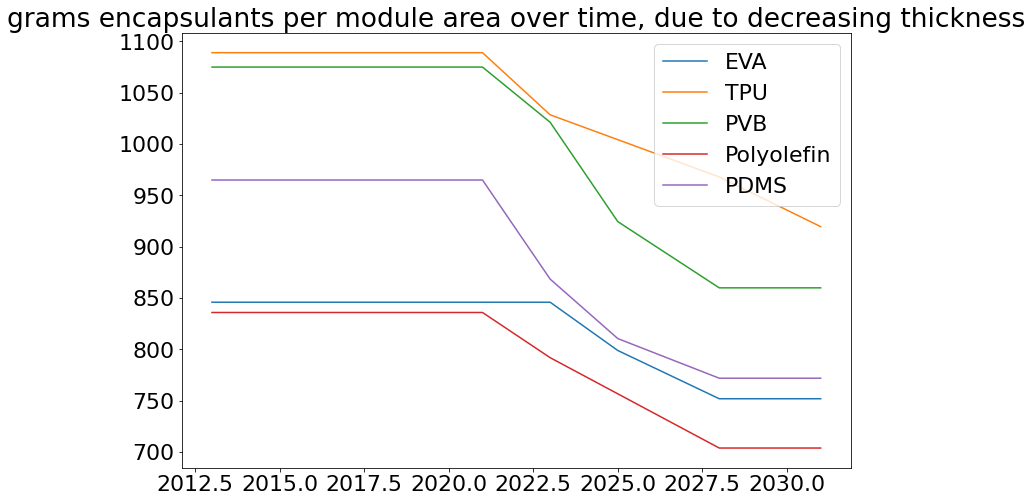

In [8]:
#multiply thickness times density to get mass per area (g/m^2)
encaps_bymat_gpm2 = pd.DataFrame(encaps_thick_m.mul(encaps_density, 'columns'))
#multiply by number of sheets of material used in PV module (usually 2)
encaps_bymat_gpm2=encaps_bymat_gpm2*2

plt.plot(encaps_bymat_gpm2)
plt.title('grams encapsulants per module area over time, due to decreasing thickness')
plt.legend(encaps_bymat_gpm2.columns)

Now aggregate it down into a single "encapsulant" baseline

In [9]:
#drop the EVA+PO column from the marketshare
encap_market = encap_market_pct_full.drop('EVA+PO', axis='columns')

#now multiply marketshare by mass per area
encaps_gpm2 = pd.DataFrame(encaps_bymat_gpm2.mul(encap_market, 'columns'))
#aggregate down to a single column
encapsulant_gpm2 = pd.DataFrame(encaps_gpm2.agg("sum", axis="columns"))
encapsulant_gpm2.columns = ['Encapsulant_g_per_m2']
print(encapsulant_gpm2)

      Encapsulant_g_per_m2
year                      
2013            846.000000
2014            848.090000
2015            850.280000
2016            852.810000
2017            847.990000
2018            848.955000
2019            851.310000
2020            849.445000
2021            809.710000
2022            782.707500
2023            778.335000
2024            756.045000
2025            720.427000
2026            692.092667
2027            680.278111
2028            668.333333
2029            670.197333
2030            671.741333
2031            673.285333
2032              0.000000


In [10]:
#print to csv
encapsulant_gpm2.to_csv(cwd+'/../../../PV_ICE/baselines/SupportingMaterial/output_encapsulant_gpm2.csv', index=True)

# Backsheets

Of the thickness of the backsheet, which is typically multilayer, there is usually an outer covering of 30-50 micron, a PET core of ~200 micron, and an inner layer of another 30-50 micron. K. J. Geretschläger, G. M. Wallner, and J. Fischer, “Structure and basic properties of photovoltaic module backsheet films,” Solar Energy Materials and Solar Cells, vol. 144, pp. 451–456, Jan. 2016, doi: 10.1016/j.solmat.2015.09.060., M. Owen-Bellini, “An Overview of Backsheet Materials for Photovoltaic Modules,” presented at the DuraMat, NREL Webinar, May 2020. Accessed: Sep. 22, 2021. [Online]. Available: https://www.duramat.org/assets/pdfs/duramat_webinar_may2020.pdf

ITRPVs breakdown marketshares of backsheets approximately into Kynar-based, Tedlar-based, Polyolefins, and "other". Moreover, there has been a shift from Tedlar to Kynar since 2016. Therefore, given the data we have, we will generalize 3 types of backsheets:
1. Kynar-based
2. Tedlar-based
3. "Other"

The Kynar (PVDF) and Tedlar (PVF) multilayer films will use a ratio structure of film-PETcore-film, which will scale with the backsheet thickness over time. The other will be....?

### Create Density Structures

In [11]:
#Densities of Plastic components
density_pet = 1.4 #g/cm^3, https://en.wikipedia.org/wiki/Polyethylene_terephthalate
density_tedlar = 1.54 #g/cm^3, “DuPont Tedlar (PVF): General Properties.” DuPont, 2014. https://www.dupont.com/content/dam/dupont/amer/us/en/photovoltaic/public/documents/DEC_Tedlar_GeneralProperties.pdf
density_kynar = 1.78 #g/cm^3, “Kynar 740 PVDF Material Data Sheet.” Professional Plastics.
#density_polyolefin = 
#density_polyester = 
density_polyamid = 1.3 #g/cm^3, APPROX https://omnexus.specialchem.com/polymer-properties/properties/density
density_aluminum = 2.7 #g/cm^3, https://en.wikipedia.org/wiki/Aluminium

In [12]:
rep_thickness = 40+200+40 # see references above
innerlayer = 40/rep_thickness 
outerlayer = 40/rep_thickness
core = 200/rep_thickness

In [13]:
film_density_kynar = density_kynar*innerlayer + density_kynar*outerlayer + density_pet*core
film_density_tedlar = density_tedlar*innerlayer + density_tedlar*outerlayer + density_pet*core
film_density_other = density_pet #this is an approximate assumption

In [14]:
print('The estimated density of a composite tedlar film is '+str(film_density_tedlar)+'g/cm^3')
print('The estimated density of a composite kynar film is '+str(film_density_kynar)+'g/cm^3')


The estimated density of a composite tedlar film is 1.44g/cm^3
The estimated density of a composite kynar film is 1.5085714285714285g/cm^3


### Thickness Data

Due to a lack of more precise data, we are going to assume that all backsheet materials are approximately the same thickness, and therefore one backsheet thickness will be used.

In [15]:
cwd = os.getcwd() #grabs current working directory
skipcols = ['Source', 'Notes']
backsheet_thickness_raw = pd.read_csv(cwd+"/../../../PV_ICE/baselines/SupportingMaterial/input-backsheetThickness.csv",
                                     index_col='year', usecols=lambda x: x not in skipcols)

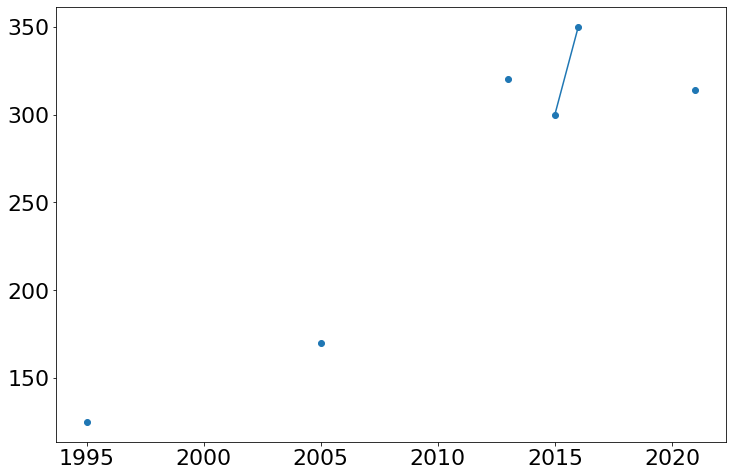

In [16]:
plt.plot(backsheet_thickness_raw,  marker='o')

Knowing that some of these points are intended as guidelines:

1. the 2015 data point at 300 micron is a minimum thickness specified by IEC 61730 safety standard
2. The 2021 data point is the rough average of backsheet materials found on ENF, “Solar Backsheet Directory.” https://www.enfsolar.com/pv/backsheet (accessed Aug. 31, 2021).
3. the 2016 data point is the median of some commercially available films that were crossectioned and analyzed in K. J. Geretschläger, G. M. Wallner, and J. Fischer, “Structure and basic properties of photovoltaic module backsheet films,” Solar Energy Materials and Solar Cells, vol. 144, pp. 451–456, Jan. 2016, doi: 10.1016/j.solmat.2015.09.060.

Therefore, we will use the 2016 data point as representative of the market during that time. 

In [17]:
backsheet_thickness_cleaned = backsheet_thickness_raw
#removing the "min" requirement from IEC std
backsheet_thickness_cleaned.loc[2015] = np.NaN 
#using literature data, since I don't think it's gotten much thinner on average
backsheet_thickness_cleaned.loc[2021] = backsheet_thickness_cleaned.loc[2016] 
#lacking a projection, we will assume constant thickness through 2050
backsheet_thickness_cleaned.loc[2050]=backsheet_thickness_cleaned.loc[2021]
#interpolate for missing years
backsheet_thickness_cleaned.interpolate(method='linear',axis=0,inplace=True)

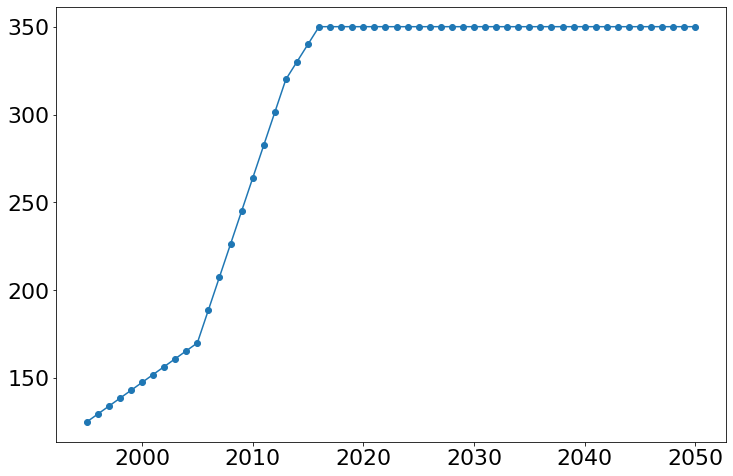

In [18]:
plt.plot(backsheet_thickness_cleaned, marker='o')

### Marketshare Data

In [19]:
cwd = os.getcwd() #grabs current working directory
skipcols = ['Source', 'Notes']
backsheet_market_raw = pd.read_csv(cwd+"/../../../PV_ICE/baselines/SupportingMaterial/Marketshare-Backsheet.csv",
                                     index_col='year', usecols=lambda x: x not in skipcols)

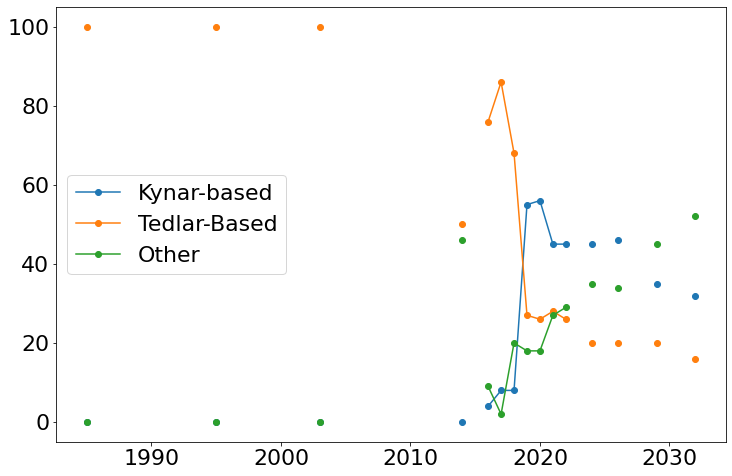

In [20]:
plt.plot(backsheet_market_raw, marker='o')
plt.legend(backsheet_market_raw.columns)

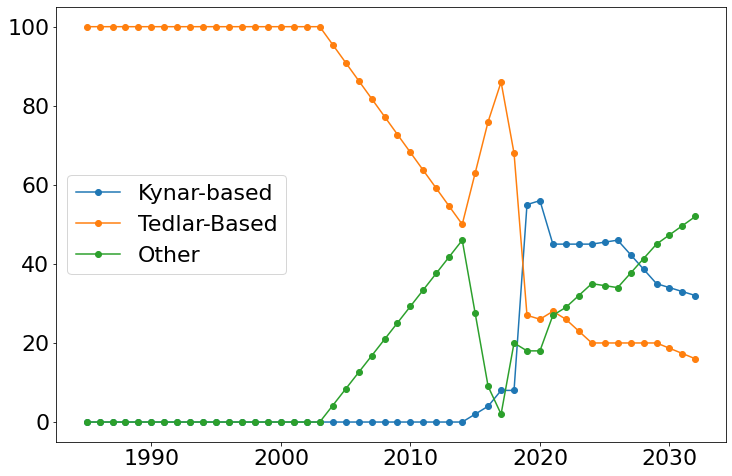

In [21]:
backsheet_market_full = backsheet_market_raw.interpolate(method='linear',axis=0,limit_area='inside')

plt.plot(backsheet_market_full, marker='o')
plt.legend(backsheet_market_full.columns)

In [22]:
#check that the columns add up to 100%
backsheet_market_full['total'] = backsheet_market_full.sum(axis=1)
backsheet_market_full.head()


,Kynar-based,Tedlar-Based,Other,total
year,,,,
1985,0.0,100.0,0.0,100.0
1986,0.0,100.0,0.0,100.0
1987,0.0,100.0,0.0,100.0
1988,0.0,100.0,0.0,100.0
1989,0.0,100.0,0.0,100.0


In [23]:
#not all add up to 100%, some of these had glass accounted for
backsheet_market_full['Scale'] = 100/backsheet_market_full['total']
backsheet_market_full['Kynar-based_scaled']= backsheet_market_full['Scale']*backsheet_market_full['Kynar-based']
backsheet_market_full['Tedlar-Based_scaled']= backsheet_market_full['Scale']*backsheet_market_full['Tedlar-Based']
backsheet_market_full['Other_scaled']= backsheet_market_full['Scale']*backsheet_market_full['Other']

In [24]:
backsheet_market_corrected = backsheet_market_full[['Kynar-based_scaled','Tedlar-Based_scaled','Other_scaled']]
backsheet_market_corrected=backsheet_market_corrected.dropna()

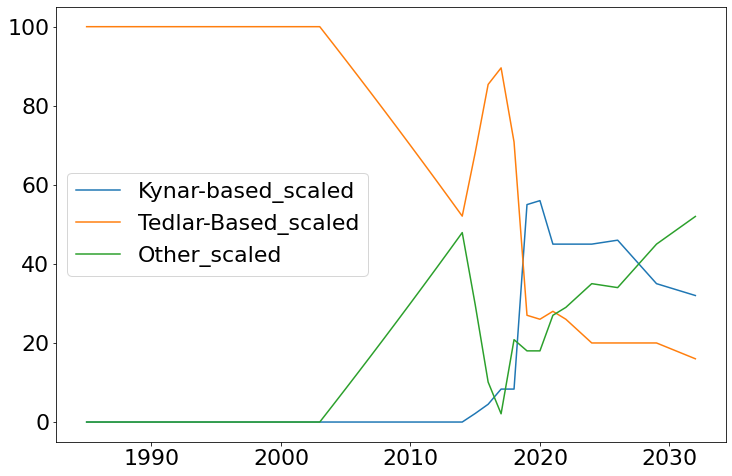

In [25]:
plt.plot(backsheet_market_corrected)
plt.legend(backsheet_market_corrected.columns)

## Combining data into average backsheet annually

First, we will combine the marketshare and densities to create an average annual density of backsheet films. Then this will be multiplied by thickness to get a mass per area annually.

In [26]:
density_marketshared = pd.DataFrame()
density_avg_annual = pd.DataFrame()

In [27]:
density_marketshared['Kynar'] = (backsheet_market_corrected['Kynar-based_scaled']/100)*film_density_kynar
density_marketshared['Tedlar'] = (backsheet_market_corrected['Tedlar-Based_scaled']/100)*film_density_tedlar
density_marketshared['Other'] = (backsheet_market_corrected['Other_scaled']/100)*film_density_other

In [28]:
density_avg_annual['Backsheet_Density_g/cm3'] = density_marketshared.sum(axis=1)

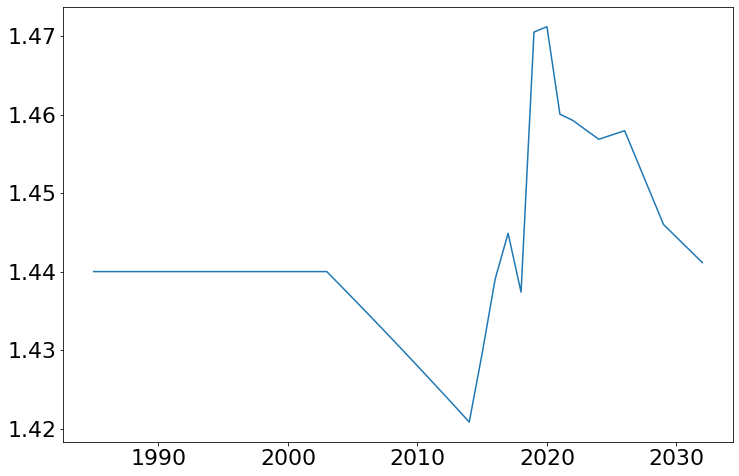

In [29]:
plt.plot(density_avg_annual)

The annual density is in g/cm3, and the thickness data is in micron. We need to get to g/m2.

In [30]:
density_avg_gpm3 = density_avg_annual*1E6 #convert to g/m3
thickness_m = backsheet_thickness_cleaned*0.000001 #convert micron to m

In [31]:
thickness_m_sub = thickness_m.loc[(thickness_m.index>=1995) & (thickness_m.index<=2031)]
density_avg_gpm3_sub = density_avg_gpm3.loc[(density_avg_gpm3.index>=1995) & (density_avg_gpm3.index<=2031)]
thickness_m_sub.columns = density_avg_gpm3_sub.columns

In [32]:
backsheet_gpm2 = thickness_m_sub*density_avg_gpm3_sub
backsheet_gpm2.columns = ['Backsheet_gpm2']

Text(0, 0.5, 'Backsheet Mass [g/m^2]')

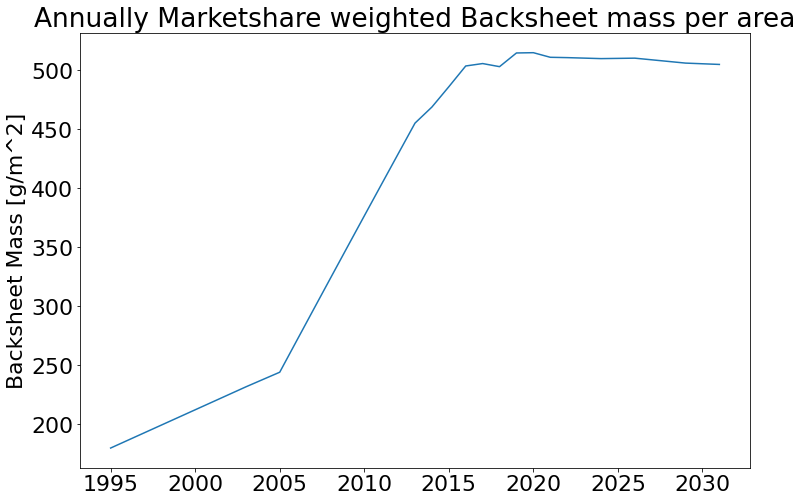

In [33]:
plt.plot(backsheet_gpm2)
plt.title('Annually Marketshare weighted Backsheet mass per area')
plt.ylabel('Backsheet Mass [g/m^2]')

### Weight by glass vs film backsheet market share

In [34]:
#pull in glass vs backsheet conformation market share fraction from glass journal output
conform_market = pd.read_csv(cwd+"/../../../PV_ICE/baselines/SupportingMaterial/output_marketshare_glassVbacksheet.csv",
                                     index_col=0)

In [35]:
conform_market.tail()

,glass-backsheet,glass-glass,foil-foil
Year,,,
2046,0.55,0.43,0.02
2047,0.55,0.43,0.02
2048,0.55,0.43,0.02
2049,0.55,0.43,0.02
2050,0.55,0.43,0.02


In [36]:
#eqn = gpm2 * marketshare g-b
backsheet_gpm2_final = backsheet_gpm2['Backsheet_gpm2']*conform_market['glass-backsheet']

In [37]:
backsheet_gpm2_final.to_csv(cwd+"/../../../PV_ICE/baselines/SupportingMaterial/output-Backsheet-gpm2.csv")